In [2]:
import pandas as pd 
import numpy as np
import json
import pprint
from scipy import stats
from collections import  Counter
from scipy.stats import entropy
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pyclustering
from pyclustering.utils import calculate_distance_matrix	
from pyclustering.utils.metric import *
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from scipy.spatial import distance 
from sklearn.utils import validation
from sklearn.metrics import pairwise
from scipy.sparse import issparse
import gw


In [4]:
data = pd.read_csv('Data/USvideos.csv')
samples = data.sample(n=50)
new_df = pd.DataFrame(samples,columns = ['views', 'comment_count','category_id','trending_date','tags'])
new_df = new_df.dropna()
def cleanString(incomingString):
    newstring = incomingString
    newstring = newstring.replace("\"","")
    newstring = list(filter(None,newstring.split('|')))
    return newstring

tagsList = []
tagsList = [ cleanString(col['tags']) for idx,col in new_df.iterrows()] 
new_df['tags'] = tagsList
def normalize(col):
    min = np.min(col)
    max = np.max(col)
    range = max - min

    return [(item - min) / range for item in col]
new_df['views'], new_df['comment_count'] = normalize(new_df['views']), normalize(new_df['comment_count'])
new_df


,views,comment_count,category_id,trending_date,tags
15886,0.000000,0.000000,24,18.03.02,"[9-1-1, first responders, police, firefighters..."
12654,0.100901,0.090491,17,18.18.01,"[Highlights, Highlight Heaven, paul allen, pau..."
16447,0.007736,0.002457,2,18.06.02,"[Toyota, Toyotathon, ToyotaUSA, Let's Go Place..."
22209,0.045291,0.041025,24,18.07.03,"[Oscars, Oscar Winning, Oscar Awards, GUESS TH..."
8136,0.061514,0.079191,10,17.24.12,"[Selena, Gomez, Marshmello, Wolves, Interscope..."
17892,0.046707,0.082853,28,18.13.02,"[HomePod Review, HomePod features, HomePod, iJ..."
620,0.010961,0.026040,24,17.17.11,"[The Talk, Julie Chen, Aisha Tyler, Sharon Osb..."
250,0.004503,0.000692,17,17.15.11,"[Ice Boats, Lake Geneva, 5D Mark II, Fontana, ..."
25170,0.034522,0.056211,24,18.22.03,"[Wendy, Williams, return, to, TV, host, health..."
25434,0.029672,0.025370,28,18.23.03,"[Hydraulic press channel, hydraulicpresschanne..."


In [6]:
def ent(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  return entropy(counts, base=base)
cat_count = 32
for col in new_df:
    e = ent(new_df[col],len(new_df[col]))
    print(col+" entropy = ",e)

views entropy =  0.9999999999999999
comment_count entropy =  0.983150217361037
category_id entropy =  0.5877125731724018
trending_date entropy =  0.9548008061393478
tags entropy =  0.9929126471945775


Text(0, 0.5, 'comments')

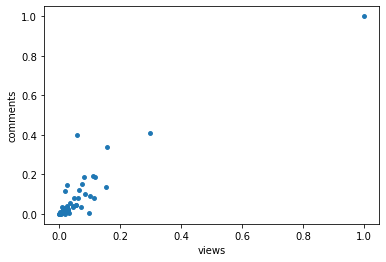

In [8]:
df = pd.DataFrame(new_df, columns = ['views','comment_count'])
df = df.iloc[:,[0,1]].values
plt.scatter(df[:,0], df[:,1],s=15)
plt.xlabel("views")
plt.ylabel("comments")

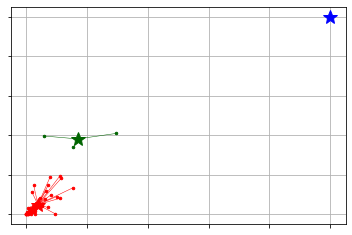

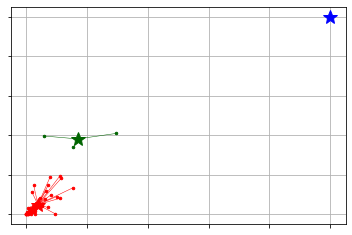

In [10]:
initial_centers = kmeans_plusplus_initializer(df, 3).initialize()
# Create instance of K-Means algorithm with prepared centers.
kmeans_instance = kmeans(df, initial_centers)
k=kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()
# Visualize obtained results
kmeans_visualizer.show_clusters(df, clusters, final_centers)

In [12]:
# import gower
# df = pd.DataFrame(new_df, columns = ['views','comment_count','category_id','trending_date'])
# dm = gower.gower_matrix(df)
# dm[0]

In [14]:
df = pd.DataFrame(new_df, columns = ['views','comment_count','category_id'])
df = df.iloc[:,[0,1,2]].values.tolist()
gd = gw.gower_distances(df).tolist()
gd

[False False False]


2019806,
  0.6752594113349915,
  0.04414506256580353,
  0.05927107483148575,
  0.1956900805234909,
  0.026892365887761116,
  0.04231053218245506,
  0.4107632339000702,
  0.05259130895137787,
  0.18562859296798706,
  0.021382898092269897,
  0.31581026315689087,
  0.028073998168110847,
  0.03955811262130737,
  0.16015625,
  0.11619409918785095,
  0.19431740045547485,
  0.043034374713897705,
  0.10497596114873886,
  0.2756251096725464,
  0.0,
  0.30381712317466736,
  0.05280502140522003,
  0.030847927555441856,
  0.3088110089302063,
  0.09443489462137222,
  0.08626525104045868,
  0.09778247028589249,
  0.02275104448199272,
  0.11503714323043823,
  0.018249744549393654,
  0.050798725336790085,
  0.11701756715774536,
  0.03898371756076813,
  0.06934009492397308,
  0.07395431399345398,
  0.02552046999335289,
  0.035427726805210114],
 [0.2872442305088043,
  0.2408389151096344,
  0.021942082792520523,
  0.2891468405723572,
  0.1406097263097763,
  0.35118067264556885,
  0.28366491198539734,
  0

In [16]:

initial_medoids = [1, 10]

#metric = distance_metric(type_metric.GOWER,data = df)
# create K-Medoids algorithm with specific distance metric
kmedoids_instance = kmedoids(gd, initial_medoids)
# run cluster analysis and obtain results
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
print(clusters)
print()
medoids = kmedoids_instance.get_medoids()
print(medoids)


[[14, 0, 1, 3, 5, 6, 7, 8, 9, 11, 12, 15, 17, 18, 20, 21, 22, 24, 25, 26, 27, 29, 30, 32, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [23, 2, 4, 10, 13, 16, 19, 28, 31, 33, 36]]

[14, 23]


In [18]:
visualizer = cluster_visualizer_multidim()


In [20]:
visualizer.append_clusters(clusters,df)


In [289]:
visualizer.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()